In [1]:
import gensim
import logging
import urllib.request

import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymystem3 import Mystem
m = Mystem()

Переводим csv в словарь для дальнейшей работы с ним:

In [1]:
import csv
fpath='princess_corpus.csv'
with open('princess_corpus.csv') as f:
    file_data=csv.reader(f)
    headers=next(file_data)
    princess_dict = [dict(zip(headers,i)) for i in file_data]
print(princess_dict[0:1])


[{'Disney_Period': 'EARLY', 'Text': 'slave in the magic mirror come from the farthest space through wind and darkness i summon thee. speak ! let me see thy face. ', 'Speaker_Status': 'NON-P', 'Movie': 'Snow White ', 'Speaker': 'queen', 'Year': '1937', 'UTTERANCE_NUMBER': '1'}]


In [14]:
import pandas as pd
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import wordpunct_tokenize

morph = MorphAnalyzer()

from wordcloud import WordCloud
from nltk.corpus import stopwords

Создаём файлы с репликами за период:

In [15]:
early = open('early.txt', 'w', encoding = 'UTF-8')
ear_text = []
for film in princess_dict:
    if film['Disney_Period'] ==  'EARLY':
        print(film['Text'], file=early)
early.close()

df = pd.read_csv("princess_corpus.csv", parse_dates=[1, 2])

Средняя длина реплики за период:

In [31]:
f = open('late.csv', 'r', encoding = 'utf-8')
mean = []
for line in f:
    new_line = line.split()
    mean.append(len(new_line))
f.close()
sum = 0
n = 0
for number in mean:
    sum+=int(number)
    n+=1
print(mean[0:10])
print(sum//n)

[1, 29, 46, 11, 57, 13, 20, 28, 18, 7]
13


Пропишем датафреймы по периодам:

In [20]:
ef = pd.read_csv("early.csv", parse_dates=[1, 2])
mf = pd.read_csv('mid.csv', parse_dates=[1, 2])
lf = pd.read_csv('late.csv', parse_dates=[1, 2])

Сделаем облака слов по периодам:

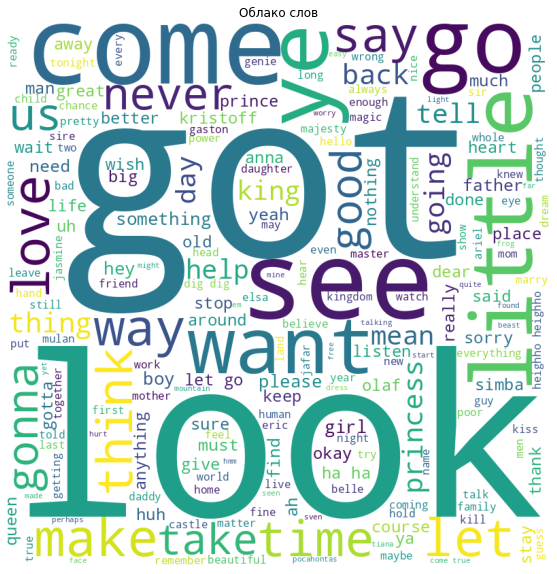

In [26]:
stops = set(stopwords.words('english') + ['don', 't', 'oh', 'know', 'well', 'right', 'one'])

def lemmatize(x):
    if type(x) != str:
        return ""
    text = wordpunct_tokenize(x)
    result = []
    for word in text:
        if word.isalpha():
            nf = morph.parse(word)[0].normal_form
            if nf not in stops:
                result.append(nf)
    return " ".join(result)

text = ' '.join(df['Text'].apply(lemmatize).values)

import matplotlib.pylab as plt

wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(text)

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов')
plt.show()

Создаём текстовые файлы с репликами принцессы, принца и всех остальных персонажей по каждому мультику для дальнейшей работы:

In [51]:
snow_nonp = open('lamp_nonp.txt', 'w', encoding = 'UTF-8')
articles_texts = []
for film in princess_dict:
    if film['Movie'] == 'Aladdin ' and film['Speaker_Status']=='NON-P':
        print(film['Text'], file=snow_nonp)
        articles_texts.append(film['Text'])
snow_nonp.close()

snow_prs = open('sleep_prs.txt', 'w', encoding = 'UTF-8')
#articlesprs_texts = []
for film in princess_dict:
    if film['Movie'] == 'Sleeping Beauty ' and film['Speaker_Status']=='PRINCESS':
        print(film['Text'], file=snow_prs)
        #articlesprs_texts.append(film['Text'])
snow_prs.close()

snow_prn = open('snow_prn.txt', 'w', encoding = 'UTF-8')
#articlesprn_texts = []
for film in princess_dict:
    if film['Movie'] == 'Snow White ' and film['Speaker_Status']=='PRINCE':
        print(film['Text'], file=snow_prn)
        #articlesprn_texts.append(film['Text'])
snow_prn.close()

In [38]:
import numpy as np
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

Считаем тф-идф для реплик каждого персонажа (принц, принцесса, другие) и выделяем несколько ключевых слов:

In [39]:
stops = stopwords.words("english")

tfidf = TfidfVectorizer(
    analyzer="word",
    stop_words=stops,
    ngram_range=(1, 3), 
    min_df=3
)

In [52]:
articles_preprocessed = []
punct_signs=',?!==\'".*&^;:–-().[];/#~%@'
for a_text in articles_texts:
    a_new_lem = ''
    a_tokens = wordpunct_tokenize(a_text)
    a_lemmatized = " ".join([morph.parse(item)[0].normal_form for item in a_tokens])
    a_lemmatized = a_lemmatized.split()
    for word in a_lemmatized:
        if word not in punct_signs:
            a_new_lem += word + ' '
    articles_preprocessed.append(a_new_lem)

In [41]:
def get_top_tf_idf_words(tfidf_vector, feature_names, top_n):
    sorted_nzs = np.argsort(tfidf_vector.data)[:-(top_n+1):-1]
    return feature_names[tfidf_vector.indices[sorted_nzs]]

In [53]:
articles_tfidf = tfidf.fit_transform(articles_preprocessed)
print(f"Матрица на {articles_tfidf.shape[0]} документов и {articles_tfidf.shape[1]} термов")

Матрица на 482 документов и 200 термов


In [55]:
feature_names = np.array(tfidf.get_feature_names())
article_vector = articles_tfidf
words = get_top_tf_idf_words(article_vector, feature_names, 10)
print(words)

['jasmine' 'snake' 'treasure' 'obviously' 'like' 'lamp' 'reward' 'reward'
 'jafar' 'ah']


/home/sofia1236/hws/hw3/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
